In [9]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 20000)
pd.options.mode.chained_assignment = None #Ignore Error: SettingWithCopyWarning
import math
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import os
import keras
import tensorflow as tf
from keras.layers import Input, Flatten, Dense, Lambda, Reshape, Dropout
from keras.layers import BatchNormalization
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.metrics import mse, accuracy
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K

keras.backend.clear_session()

# Load the data

In [10]:
df = pd.read_csv('../data/preprocessed/cleaned_data_agg_v1.csv', delimiter=",")
#df = pd.read_csv('../data/preprocessed/cleaned_data_v8.csv', delimiter=",")

key_list = df.keys().tolist()

for x in range(len(key_list)):
    if not df.columns[x] == "datum":
        if not df.columns[x] == "container_id":
            df = df.astype({key_list[x]: "float32"})

# Delete unwanted data; cast datetime

In [11]:
# set date as index ancd convert to float
df['datum'] = pd.to_datetime(df['datum'])
df = df.set_index(df['datum'])
df = df.sort_index()
df['datum_float'] = df['datum'].values.astype(float)
df = df.drop(columns=["height_in_cm", "datum"])
df = df.astype('float32')

# Split into train/test

In [106]:
# create train test partition
training_set = df['2020-05-09 00:00:00':'2021-01-29 23:59:59']
test_set  = df['2021-01-30 00:00:00':]
print('Train Dataset:',training_set.shape)
print('Test Dataset:',test_set.shape)

Train Dataset: (19142, 24)
Test Dataset: (7539, 24)


C:\Users\david\AppData\Local\Temp/ipykernel_9376/614333153.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  training_set = df['2020-05-09 00:00:00':'2021-01-29 23:59:59']
C:\Users\david\AppData\Local\Temp/ipykernel_9376/614333153.py:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_set  = df['2021-01-30 00:00:00':]


In [107]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19142 entries, 2020-05-09 19:40:46.486563 to 2021-01-29 23:58:02.169932
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   container_id         19142 non-null  float32
 1   temperatur_in_grad   19142 non-null  float32
 2   aussentemperatur     19142 non-null  float32
 3   niederschlag_in_mm   19142 non-null  float32
 4   ist_industriegebiet  19142 non-null  float32
 5   ist_wohngebiet       19142 non-null  float32
 6   ist_feiertag         19142 non-null  float32
 7   sekunde              19142 non-null  float32
 8   minute               19142 non-null  float32
 9   stunde               19142 non-null  float32
 10  wochentag            19142 non-null  float32
 11  kalenderwoche        19142 non-null  float32
 12  monat                19142 non-null  float32
 13  jahr                 19142 non-null  float32
 14  farbe_brown          19142 non-null  

# Prepare the training data

In [108]:
#https://towardsdatascience.com/lstm-time-series-forecasting-predicting-stock-prices-using-an-lstm-model-6223e9644a2f
#https://analyticsindiamag.com/hands-on-guide-to-lstm-recurrent-neural-network-for-stock-market-prediction/
# Feature Scaling

# ****************** START TUNING *************
timelag = 3 #10
epochs_number = 5 #10
batch_size_number = 16 #32
container_number = 2

# ****************** END TUNING *************
# Select container
training_set = training_set[training_set['container_id']==container_number]

# MinMax Scale x train set
sc = MinMaxScaler(feature_range = (0, 1))
train_set_all_scaled = training_set.drop(columns=["hight_delta"])
train_set_all_scaled = sc.fit_transform(train_set_all_scaled)

# MinMax Scale y train set
train_set = training_set.iloc[:, 20:21].values
sc2 = MinMaxScaler(feature_range = (0, 1))
train_set_scaled = sc2.fit_transform(train_set)

X_train = []
y_train = []
for i in range(timelag, len(training_set)-1):
    X_train.append(train_set_all_scaled[i-timelag:i,:])
    y_train.append(train_set_scaled[i,:]) 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 23))

# Configure the model

In [109]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 23)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

#first callback method
#reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, verbose=1,
#patience=25, min_lr=0.0000001, min_delta=0.0001)
#default value lr = 0.001
#callbacks = [reduce_lr]

# Second callback mehod
#es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train the model

Epoch 1/5
17/17 [==============================] - 22s 21ms/step - loss: 0.2688
Epoch 2/5
17/17 [==============================] - 0s 21ms/step - loss: 0.1962
Epoch 3/5
17/17 [==============================] - 0s 22ms/step - loss: 0.1880
Epoch 4/5
17/17 [==============================] - 0s 21ms/step - loss: 0.1233
Epoch 5/5
17/17 [==============================] - 0s 22ms/step - loss: 0.0555


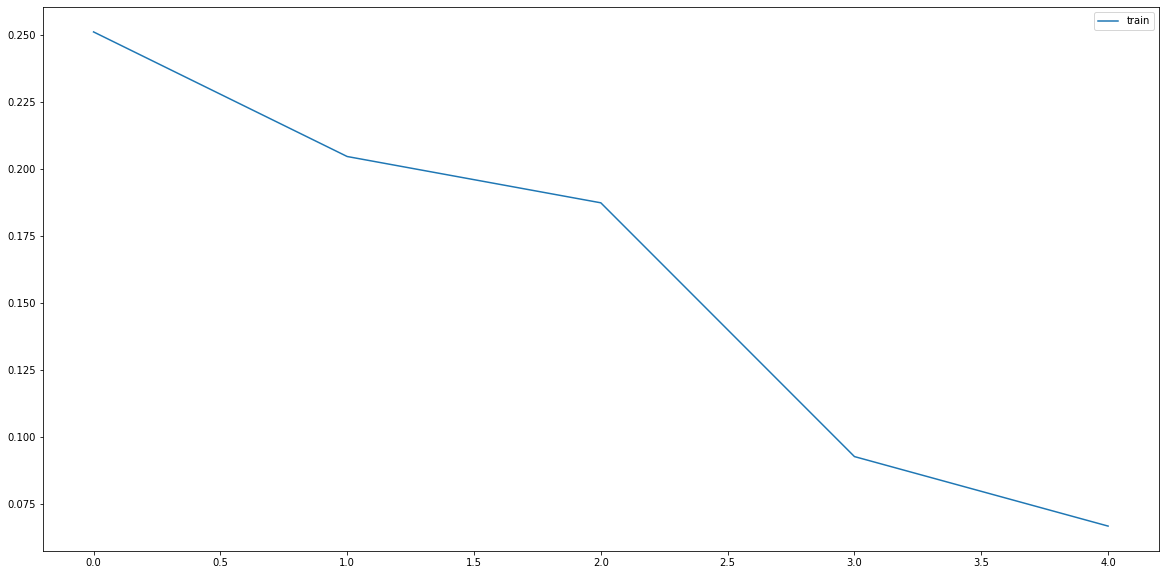

In [110]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = regressor.fit(X_train, y_train, epochs = epochs_number, batch_size = batch_size_number)
#, callbacks = callbacks
# callbacks=[es_callback]
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

# Prepare the test data

In [96]:
#test_set_sub = test_set
test_set_sub = test_set[test_set['container_id']==container_number]
#training_set_sub = training_set
training_set_sub = training_set[training_set['container_id']==container_number]

real_height = test_set_sub.iloc[:, 20:21].values
dataset_total = pd.concat((training_set_sub, test_set_sub), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test_set_sub) - timelag:].values
#inputs = inputs.reshape(-1,24)
#inputs = sc.transform(dataset_total[len(dataset_total) - len(test_set_sub) - timelag:])

X_test = []
for i in range(timelag, len(test_set_sub)+timelag):
    X_test.append(inputs[i-timelag:i,:])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 24))

In [115]:
#test_set_sub = test_set
test_set_sub = test_set[test_set['container_id']==container_number]
#training_set_sub = training_set
training_set_sub = training_set[training_set['container_id']==container_number]

dataset_total = pd.concat((training_set_sub, test_set_sub), axis = 0)

# MinMax Scale x test set
test_set_all_scaled = dataset_total.drop(columns=["hight_delta"])
test_set_all_scaled = sc.transform(test_set_all_scaled)

# y test set
real_height = test_set_sub.iloc[:, 20:21].values

X_test = []
for i in range(timelag, len(test_set_sub)+timelag):
    X_test.append(train_set_all_scaled[i-timelag:i,:])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 23))

# Predict

In [116]:
#predicted_height = regressor.predict(X_test)

predicted_height = regressor.predict(X_test)
predicted_height = sc2.inverse_transform(predicted_height)

# Plot the prediction

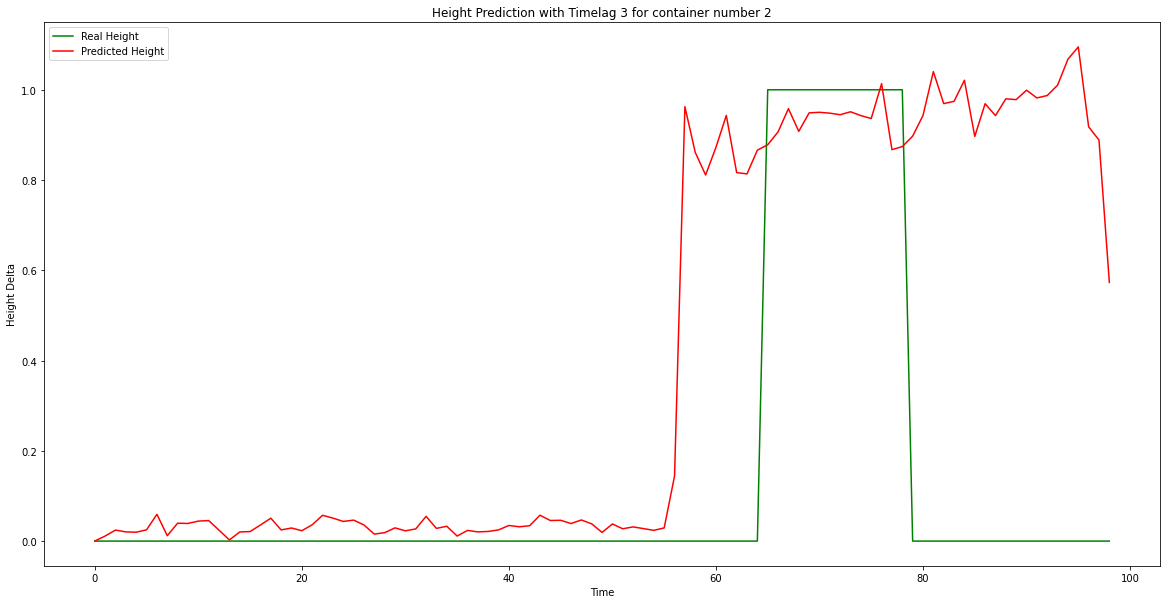

In [117]:
plt.figure(figsize=(20,10))
plt.plot(real_height, color = 'green', label = 'Real Height')
plt.plot(predicted_height, color = 'red', label = 'Predicted Height')
plt.title('Height Prediction with Timelag '+ str(timelag) + ' for container number ' +str(container_number))
plt.xlabel('Time')
plt.ylabel('Height Delta')
plt.legend()
plt.show()

# Export Model

In [ ]:
regressor.save('../data/modeling/dev/test_model')

# TEST FOR A SINGLE PREDICTION

In [ ]:
reconstructed_model = keras.models.load_model("../data/modeling/dev/test_model")

In [ ]:
test_set_sub = test_set[test_set['container_id']==1].head(1)
training_set_sub = training_set[training_set['container_id']==1]

real_height = test_set_sub.iloc[:, 20:21].values
dataset_total = pd.concat((training_set_sub['hight_delta'], test_set_sub['hight_delta']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test_set_sub) - timelag:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(timelag, len(test_set_sub)+timelag):
    X_test.append(inputs[i-timelag:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_height = reconstructed_model.predict(X_test)
predicted_height = sc.inverse_transform(predicted_height)

print("Pred ="+str(predicted_height)+" and real height = "+str(real_height))

In [ ]:
test_set_sub